# 训练脉冲神经网络

## 介绍
近几年，人们对训练脉冲神经网络（SNN）进行有意义的计算的兴趣激增。一方面，这种激增是由于更传统的、通常被认为在生物学上更合理的学习范式在创建解决有趣计算问题的功能神经网络方面取得的有限成就所推动的。深度神经网络在解决各种具有挑战性的计算问题方面取得了不可否认的成功，弥补了这一限制。这一成功既提高了标准，也提出了这一进展如何转化为脉冲神经网络的问题。

过去十年深度学习的兴起在很大程度上归功于GPU及其计算能力的提升、训练数据集的扩大，以及——或许最重要的是——对误差反向传播算法的特点和需求的理解进步。例如，我们现在知道必须避免梯度消失和爆炸问题，这一成就可以通过选择合理的非线性函数、适当的权重初始化和合适的优化器来实现。支持自动微分的强大软件包使得处理深度神经网络变得比以往更加轻松。这一发展提出了一个问题：我们能从深度学习和其工具中获得多少知识，并将其用于训练脉冲神经网络。尽管目前无法完全回答这些问题，但似乎我们可以从中学习很多。

在本教程中，我们使用[`brainstate`](https://brainstate.readthedocs.io/en/latest/)以及[Brain Dynamics Programming Ecosystem](https://ecosystem-for-brain-dynamics.readthedocs.io/en/latest/)中的工具，逐步构建一个脉冲神经网络。明确地说，我们的目标是构建解决（简单）现实世界问题的网络。为此，我们专注于分类问题，并结合上述的反向传播算法使用监督学习。为此，我们必须克服由脉冲本身的二元性质引起的梯度消失问题。

在本教程中，我们将首先展示如何将一个简单的前向传播的基于泄露整合发放（LIF）神经元和基于电导的突触脉冲神经网络（SNN）形式化地映射到离散时间循环神经网络 (RNN)。我们将利用这一公式来解释为什么在脉冲时梯度会消失，并展示一种缓解该问题的方法。具体来说，我们将引入代理梯度，并提供在Brainstate中如何实现它们的实际示例。

## 将LIF神经元映射到RNN动力学

计算神经科学中网络模拟的事实上的标准神经元模型是LIF神经元模型，它通常被正式写成微分形式的时间连续动力系统：
$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i^{(l)}}{\mathrm{d}t} = -(U_i^{(l)}-U_\mathrm{rest}) + RI_i^{(l)}$$
其中 $U_i$ 是第 $l$ 层神经元 $i$ 的膜电位，$U_\mathrm{rest}$ 是静息电位，$\tau_\mathrm{mem}$ 是膜时间常数，$R$ 是输入电阻，$I_i$ 是输入电流。膜电位 $U_i$ 表征每个神经元的隐藏状态，并且重要的是，它不会直接传递给下游神经元。然而，当神经元的膜电压超过阈值 $\vartheta$ 时，神经元会在时间 $t$ 发射动作电位或脉冲。发射脉冲后，神经元的膜电压被重置 $U_i \rightarrow U_\mathrm{rest}$。我们写作
$$S_i^{(l)}(t)=\sum_{k \in C_i^l} \delta(t-t_j^k)$$ 
表示脉冲序列（即神经元 $i$ 在第 $l$ 层发射的所有脉冲 $C_i^l$ 的总和）。这里 $\delta$ 是狄拉克δ函数，$t_i^k$ 是神经元的相关发射时间。

脉冲沿着轴突传播并在连接的神经元中产生突触后电流。使用上述形式，我们可以写作
$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j^{(0)}(t) + \sum_j V_{ij} S_j^{(1)}(t)$$
其中我们引入了突触权重矩阵 $W_{ij}$（前馈），$V_{ij}$（递归），以及突触衰减时间常数 $\tau_\mathrm{syn}$。

为了与RNN明显联系起来，我们现在将上述方程表达为离散时间形式。为了简洁起见，我们切换到自然单位 $U_\mathrm{rest}=0$，$R=1$，和 $\vartheta=1$。我们的论点不受此选择的影响，所有结果都可以重新缩放到物理单位。为了突出脉冲的非线性特征，我们首先注意到可以设置
$$S_i^{(l)}(t)=\Theta(U_i^{(l)}(t)-\vartheta)$$
其中 $\Theta$ 表示赫维赛德阶跃函数。

假设一个小的模拟时间步长 $\Delta_t>0$，我们可以通过以下方式近似突触动力学：
$$I_i^{(l)}(t+1) = \alpha I_i^{(l)}(t) + \sum_j W_{ij} S_j^{(l-1)}(t) +\sum_j V_{ij} S_j^{(l)}(t)$$
其中常数 $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$。此外，膜动力学可以写成
$$U_i^{(l)}(t+1) = \underbrace{\beta U_i^{(l)}(t)}_{\mathrm{leak}} + \underbrace{I_i^{(l)}(t)}_{\mathrm{input}} -\underbrace{S_i^{(l)}(t)}_{\mathrm{reset}}$$
其中输出 $S_i(t) = \Theta(U_i(t)-1)$ 和常数 $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$。注意方程右侧的不同项，它们分别负责：i) 泄漏，ii) 突触输入，和 iii) 脉冲重置。

这些方程可以简洁地总结为具有特定连接结构的RNN的计算图。

<p align="center">
    <img src="https://raw.githubusercontent.com/surrogate-gradient-learning/spytorch/refs/heads/master/notebooks/figures/snn_graph/snn_graph.png" alt="snn_graph"/>
</p>


时间从左到右流动。输入在每个时间步从图的底部进入网络（$S_i^{(0)}$）。这些输入依次影响突触电流 $I_i^{(1)}$，膜电位 $U_i^{(1)}$，最后是脉冲输出 $S_i^{(1)}$。此外，动态量直接输入到未来的时间步。为了清晰起见，在图中省略了索引 $i$。

计算图展示了一个称为时间展开的概念，它强调了深度神经网络和循环神经网络之间的对偶性，后者只不过是时间上的深度网络（具有绑定权重）。由于这一事实，我们可以使用时间反向传播（BPTT）来训练RNN。我们将在后面讨论由脉冲非线性的二元特性引起的问题。现在，让我们首先在Brainstate中实现上述动力学的三层脉冲神经网络。

## 示例

让我们从一个简单的多层网络模型开始，该模型具有单个隐藏层，如下所示。为了简单起见，我们暂时不使用递归连接 $V$，记住如果需要，可以在以后添加它们。

<p align="center">
    <img src="https://raw.githubusercontent.com/surrogate-gradient-learning/spytorch/refs/heads/master/notebooks/figures/mlp_sketch/mlp_sketch.png" alt="snn_graph"/>
</p>

我们首先导入所需的库。

In [1]:
import time

import braintools as bts
import brainunit as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import brainstate as bst

In [2]:
num_inputs  = 100
num_hidden  = 4
num_outputs = 2

正如我们上面所看到的，我们实际上是在模拟一个RNN。因此，我们必须为一定数量的时间步长模拟我们的神经元。我们将使用1毫秒的时间步长，并且我们希望模拟我们的网络1000个时间步长。

In [3]:
time_step = 1 * u.ms
bst.environ.set(dt=time_step)   # set the time step for the environment
num_steps  = 1000

为了利用并行性，我们将设置代码以处理数据批次，就像通常对以监督方式训练的神经网络所做的那样。
为此，我们在这里指定一个批次大小。

In [4]:
batch_size = 256

在做出这些基本设计选择之后，我们现在可以开始构建实际的网络了

### 定义脉冲神经网络(SNN)

-  **该类继承自`bst.nn.DynamicsGroup`**：
   - `bst.nn.DynamicsGroup` 是一个包含动态神经网络组件的类，用于在时间维度上模拟神经元的动力学行为。
   - 通过继承`DynamicsGroup`，`SNN`类可以利用框架提供的工具来管理脉冲神经网络的状态更新和活动模拟。

-  **`__init__`构造方法**：
   - `__init__`方法初始化网络结构，包括输入到递归层的连接、递归层的脉冲神经元模型、递归层到输出层的连接，以及输出层的处理单元。

#### 输入层到递归层的连接 (`self.i2r`)

- **`bst.nn.Sequential`**：用于顺序地组合多个层。这里包含两个层：一个线性层和一个指数衰减层。
  
- **线性层 (`bst.nn.Linear`)**：
  - 作用：将输入层的信号传递到递归层。
  - 参数：
    - `num_in`: 输入层的神经元数量。
    - `num_rec`: 递归层的神经元数量。
    - `w_init`：权重初始化方法，采用Kaiming Normal初始化，适用于ReLU等激活函数。
    - `b_init`：偏置初始化，这里设为零初始化。

- **指数衰减层 (`bst.nn.Expon`)**：
  - 作用：模拟输入信号随时间的指数衰减特性，使输入信号更符合生物神经元的动力学特性。
  - 参数：
    - `num_rec`: 指定递归层的神经元数量。
    - `tau`: 时间常数，控制指数衰减的速率，这里设置为`10 ms`。
    - `g_initializer`：初始化参数`g`的值，这里设为0，代表初始输入电流为零。

#### 递归层 (`self.r`)

- **LIF神经元模型 (`bst.nn.LIF`)**：
  - 作用：递归层使用脉冲发放的Leaky Integrate-and-Fire（LIF）神经元模型，这是一种广泛应用的生物神经元模型。
  - 参数：
    - `num_rec`: 递归层的神经元数量。
    - `tau`: 时间常数，控制电位的泄露速度，设为`20 ms`。
    - `V_reset`：脉冲发放后膜电位的复位值，这里设为`0 mV`。
    - `V_rest`：神经元静息膜电位值，也是`0 mV`。
    - `V_th`：膜电位的阈值，设为`1 mV`，超过此值神经元会发放脉冲。
    - `spk_fun`：定义脉冲发放的激活函数，这里使用`bst.surrogate.ReluGrad()`作为脉冲函数的近似求导方法。

#### 递归层到输出层的连接 (`self.r2o`)

- **线性层**：
  - 作用：将递归层的输出信号传递到输出层。
  - 参数：
    - `num_rec`: 递归层神经元数。
    - `num_out`: 输出层神经元数。
    - `w_init`：权重初始化方法，同样使用Kaiming Normal初始化。

#### 输出层 (`self.o`)

- **指数衰减层**：
  - 作用：模拟输出层信号随时间的衰减行为。
  - 参数：
    - `num_out`: 输出层神经元数。
    - `tau`: 衰减的时间常数，这里为`10 ms`。
    - `g_initializer`：输出电流初始化值设为零。

In [5]:
class SNN(bst.nn.DynamicsGroup):
    def __init__(self, num_in, num_rec, num_out):
        # 初始化父类DynamicsGroup
        super(SNN, self).__init__()

        # 参数定义
        self.num_in = num_in   # 输入层神经元数量
        self.num_rec = num_rec # 递归层神经元数量
        self.num_out = num_out # 输出层神经元数量

        # 定义从输入层到递归层的连接（突触: i->r）
        # 使用Sequential将线性层和指数衰减层连接在一起
        self.i2r = bst.nn.Sequential(
            # 线性层：用于将输入信号映射到递归层
            bst.nn.Linear(
                num_in, num_rec,  # 从输入层到递归层的连接数
                w_init=bst.init.KaimingNormal(scale=2., unit=u.mA),  # 使用Kaiming Normal初始化权重
                b_init=bst.init.ZeroInit(unit=u.mA)  # 偏置初始化为零
            ),
            # 指数衰减层：对信号进行时间上的衰减，使其符合生物神经元动力学
            bst.nn.Expon(num_rec, tau=10. * u.ms, g_initializer=bst.init.Constant(0. * u.mA))
        )

        # 定义递归层（r），采用LIF神经元模型
        self.r = bst.nn.LIF(
            num_rec,              # 递归层神经元数量
            tau=20 * u.ms,        # 时间常数，控制膜电位衰减速率
            V_reset=0 * u.mV,     # 膜电位复位值
            V_rest=0 * u.mV,      # 静息膜电位
            V_th=1. * u.mV,       # 膜电位阈值，超过此值时神经元发放脉冲
            spk_fun=bst.surrogate.ReluGrad()  # 近似求导函数，用于实现脉冲发放
        )

        # 定义从递归层到输出层的连接（突触: r->o），采用线性层
        self.r2o = bst.nn.Linear(
            num_rec, num_out,          # 从递归层到输出层的连接数
            w_init=bst.init.KaimingNormal()  # 使用Kaiming Normal初始化权重
        )

        # 定义输出层（o），使用指数衰减层模拟输出信号的时间衰减
        self.o = bst.nn.Expon(
            num_out,                    # 输出层神经元数量
            tau=10. * u.ms,             # 时间常数，控制输出信号的衰减速率
            g_initializer=bst.init.Constant(0.)  # 初始化电流为零
        )

    # update方法：用于执行网络的一次更新，返回输出层的输出
    def update(self, spike):
        # 依次通过 i2r、r、r2o 和 o 计算输出
        return self.o(self.r2o(self.r(self.i2r(spike))))

    # predict方法：用于预测并获取递归层的膜电位值、脉冲输出和最终输出
    def predict(self, spike):
        # 计算递归层的脉冲输出
        rec_spikes = self.r(self.i2r(spike))
        # 计算最终输出
        out = self.o(self.r2o(rec_spikes))
        # 返回递归层的膜电位值、递归层脉冲输出和最终输出
        return self.r.V.value, rec_spikes, out

In [17]:
net = SNN(num_inputs, num_hidden, num_outputs)

### 简单的合成数据集

我们首先生成一些随机的脉冲数据集，我们将用它作为网络的输入。最初，我们将使用单个批次的数据。

假设我们希望网络将一组不同的稀疏输入脉冲序列分类为两个类别。

为了生成一些合成数据，我们用0到1之间的随机均匀数填充一个形状为 (batch_size x num_steps x num_inputs) 的张量，并使用它来生成我们的输入数据集：

In [7]:
freq = 5 * u.Hz
x_data = bst.random.rand(num_steps, batch_size, net.num_in) < freq * bst.environ.get_dt()
y_data = u.math.asarray(bst.random.rand(batch_size) < 0.5, dtype=int)

请注意，数据中没有结构（因为它是完全随机的）。因此，我们现在不会担心泛化问题，只关心我们能否用即将构建的尖峰神经网络过度拟合这些数据。

如果绘制第一个输入模式的脉冲光栅图，这个合成数据集看起来如下所示。

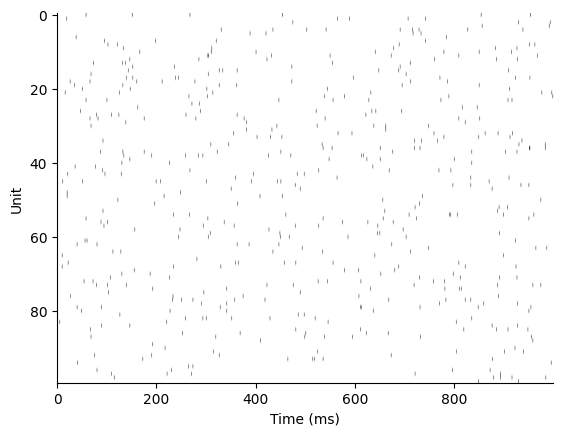

In [8]:
data_id = 0
plt.imshow(x_data.swapaxes(0, 1)[data_id].transpose(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

### 可视化神经元膜电位

定义一个辅助函数`plot_voltage_traces`，用于绘制神经元的膜电位和脉冲活动。

In [9]:
def plot_voltage_traces(mem, spk=None, dim=(3, 5), spike_height=5, show=True):
    fig, gs = bts.visualize.get_figure(*dim, 3, 3)
    if spk is not None:
        mem[spk > 0.0] = spike_height
    if isinstance(mem, u.Quantity):
        mem = mem.to_decimal(u.mV)
    for i in range(np.prod(dim)):
        if i == 0:
            a0 = ax = plt.subplot(gs[i])
        else:
            ax = plt.subplot(gs[i], sharey=a0)
        ax.plot(mem[:, i])
    if show:
        plt.show()

### 测试未训练的网络性能

在训练前测试网络，并用`plot_voltage_traces`可视化膜电位变化。

In [18]:
def print_classification_accuracy(output, target):
    """ Dirty little helper function to compute classification accuracy. """
    m = u.math.max(output, axis=0)  # max over time
    am = u.math.argmax(m, axis=1)  # argmax over output units
    acc = u.math.mean(target == am)  # compare to labels
    print("准确率 %.3f" % acc)

def predict_and_visualize_net_activity(net):
    bst.nn.init_all_states(net, batch_size=batch_size)
    vs, spikes, outs = bst.compile.for_loop(net.predict, x_data, pbar=bst.compile.ProgressBar(10))
    plot_voltage_traces(vs, spikes, spike_height=5 * u.mV, show=False)
    plot_voltage_traces(outs)
    print_classification_accuracy(outs, y_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

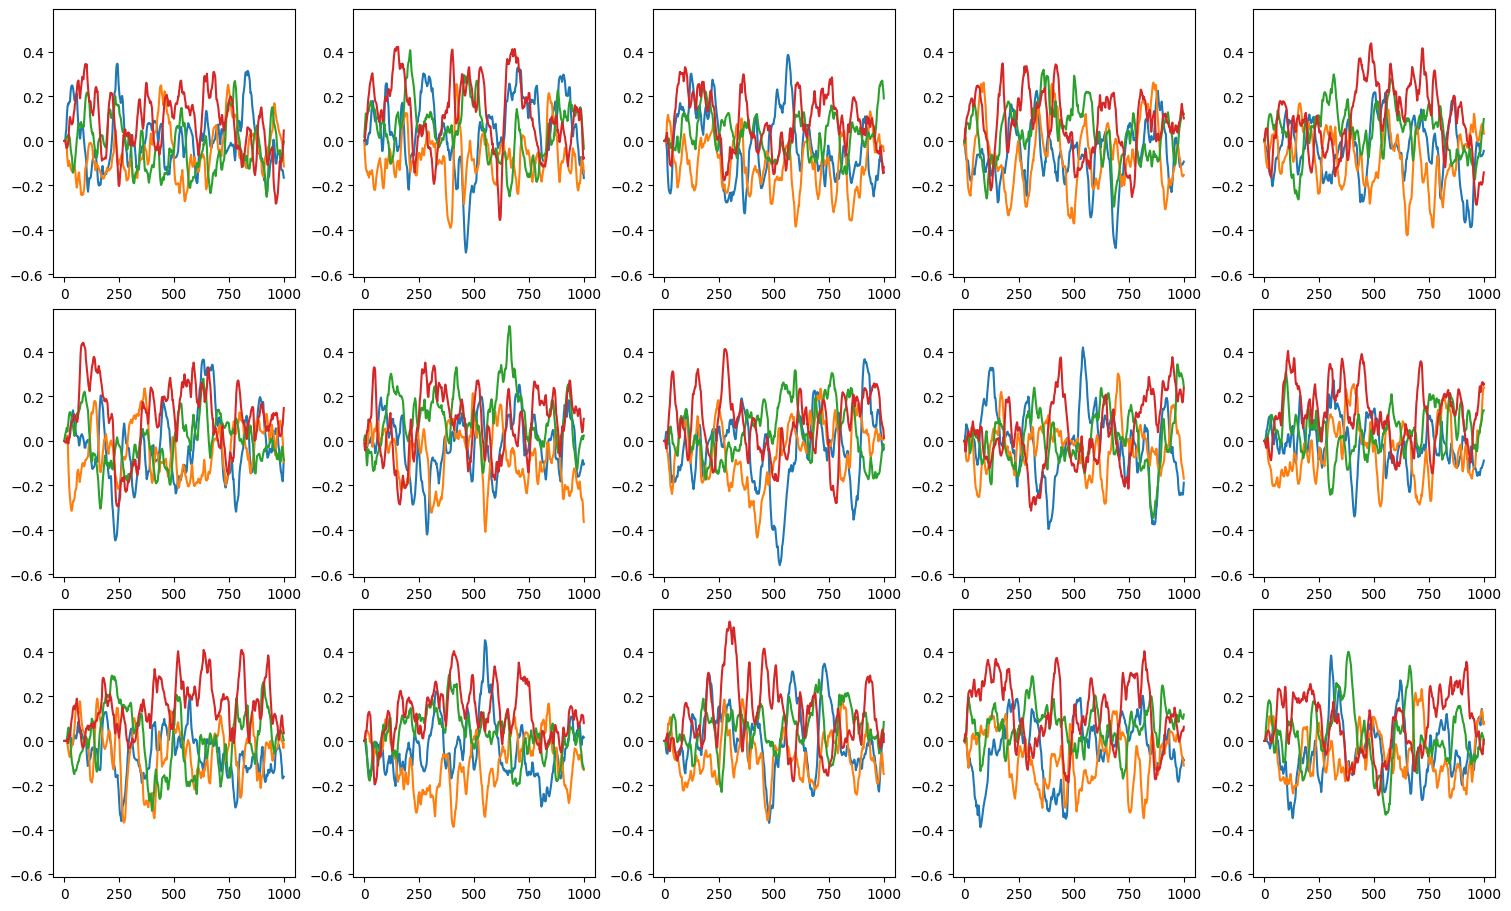

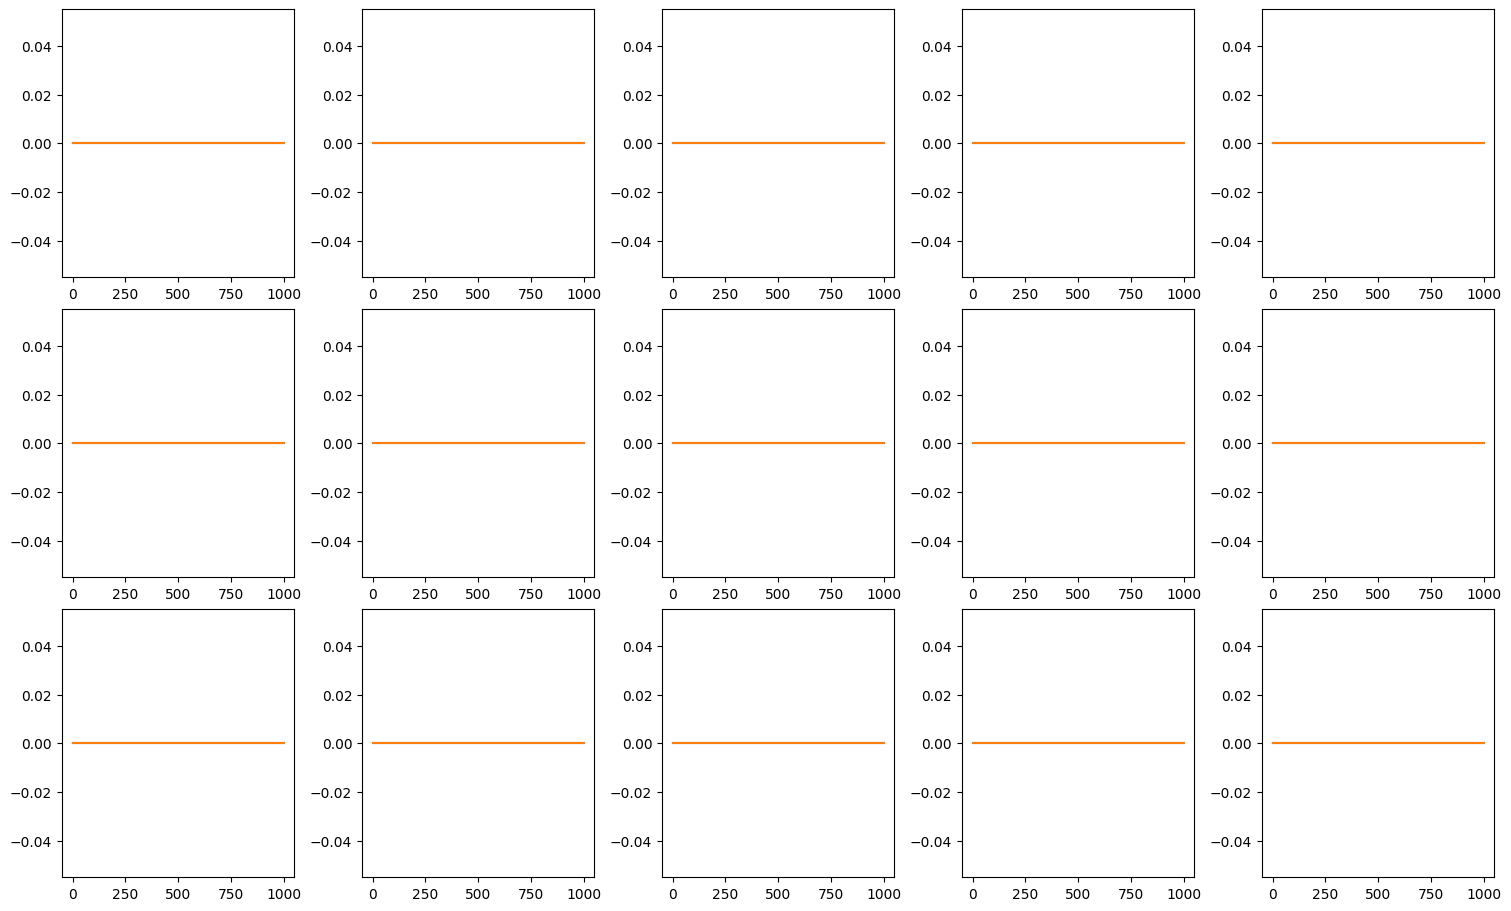

准确率 0.512


In [19]:
predict_and_visualize_net_activity(net)

如您所见，我们的随机初始化给了我们一些零星的脉冲。并且计算出这个随机网络的分类准确率。我们将看到这个准确率大约在50%左右，因为这对应于我们合成任务的随机水平。

### 定义优化器和损失函数

使用Adam优化器，并定义损失函数为交叉熵损失。

In [ ]:
optimizer = bst.optim.Adam(lr=1e-3)
optimizer.register_trainable_weights(net.states(bst.ParamState))

def loss_fn():
    predictions = bst.compile.for_loop(net.update, x_data)
    predictions = u.math.mean(predictions, axis=0)
    predictions = bst.functional.log_softmax(predictions, axis=1)
    return bts.metric.nll_loss(predictions, y_data).mean()

### 训练网络

定义训练函数并训练网络。

In [22]:
@bst.compile.jit
def train_fn():
    bst.nn.init_all_states(net, batch_size=batch_size)
    grads, l = bst.augment.grad(loss_fn, net.states(bst.ParamState), return_value=True)()
    optimizer.update(grads)
    return l

train_losses = []
for i in range(1, 1001):
    loss = train_fn()
    train_losses.append(loss)
    if i % 100 == 0:
        print(f'Epoch {i}, Loss = {loss:.4f}')

Epoch 100, Loss = -3.3882
Epoch 200, Loss = -6.5075
Epoch 300, Loss = -9.3902
Epoch 400, Loss = -12.1943
Epoch 500, Loss = -14.9768
Epoch 600, Loss = -17.7619
Epoch 700, Loss = -20.5512
Epoch 800, Loss = -23.3570
Epoch 900, Loss = -26.1947
Epoch 1000, Loss = -29.0709


### 可视化训练损失

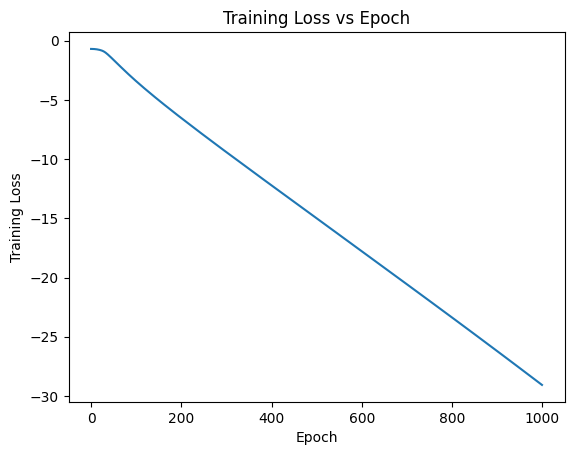

In [23]:
plt.plot(np.asarray(jnp.asarray(train_losses)))
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch")
plt.show()

### 测试网络性能


  0%|          | 0/1000 [00:00<?, ?it/s]

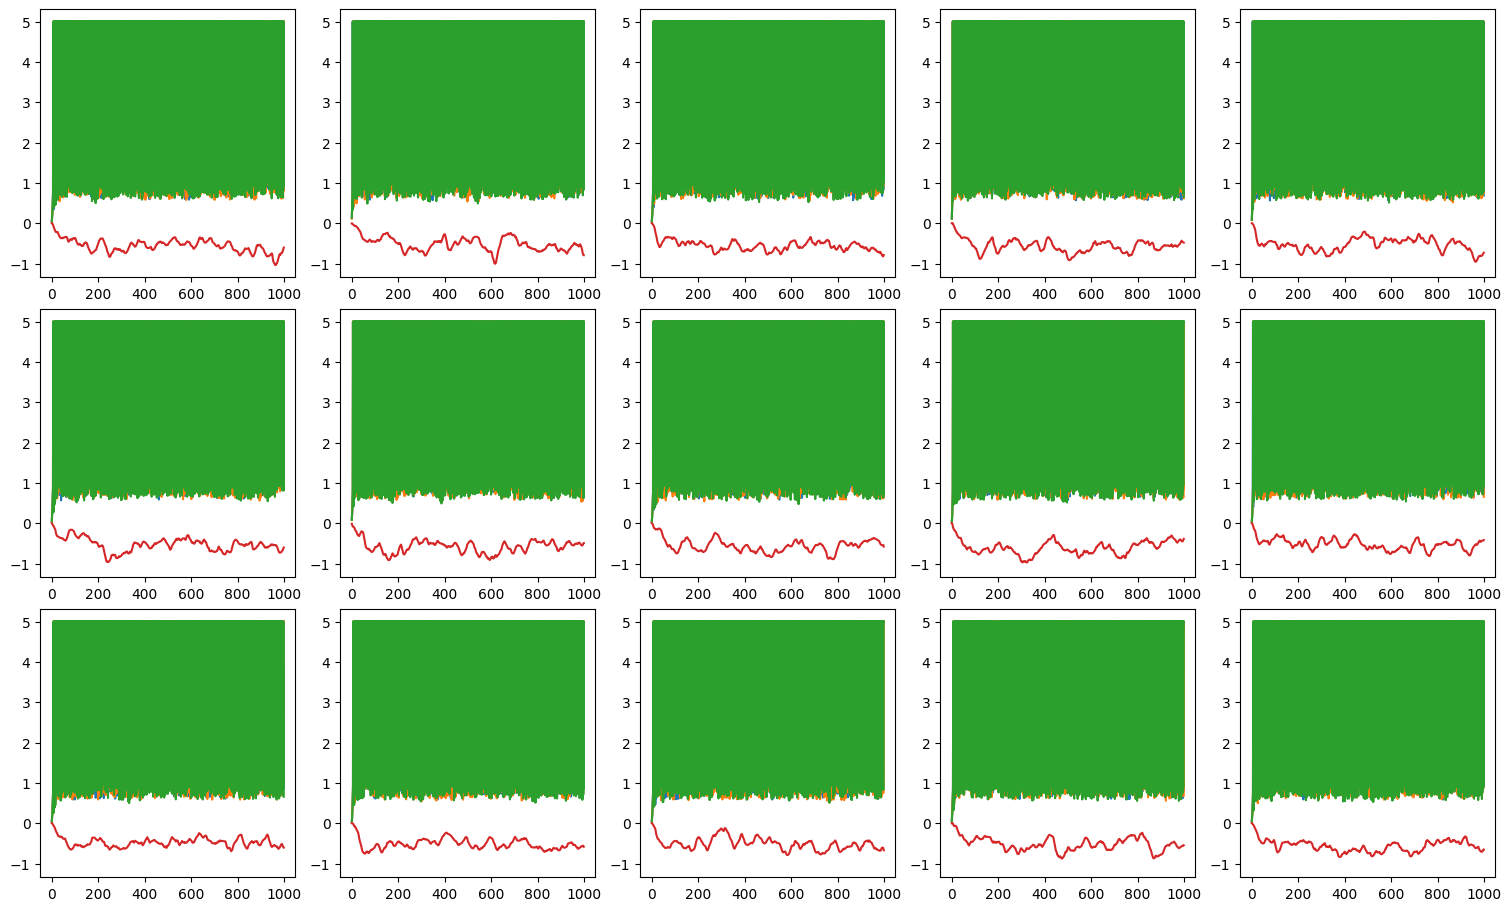

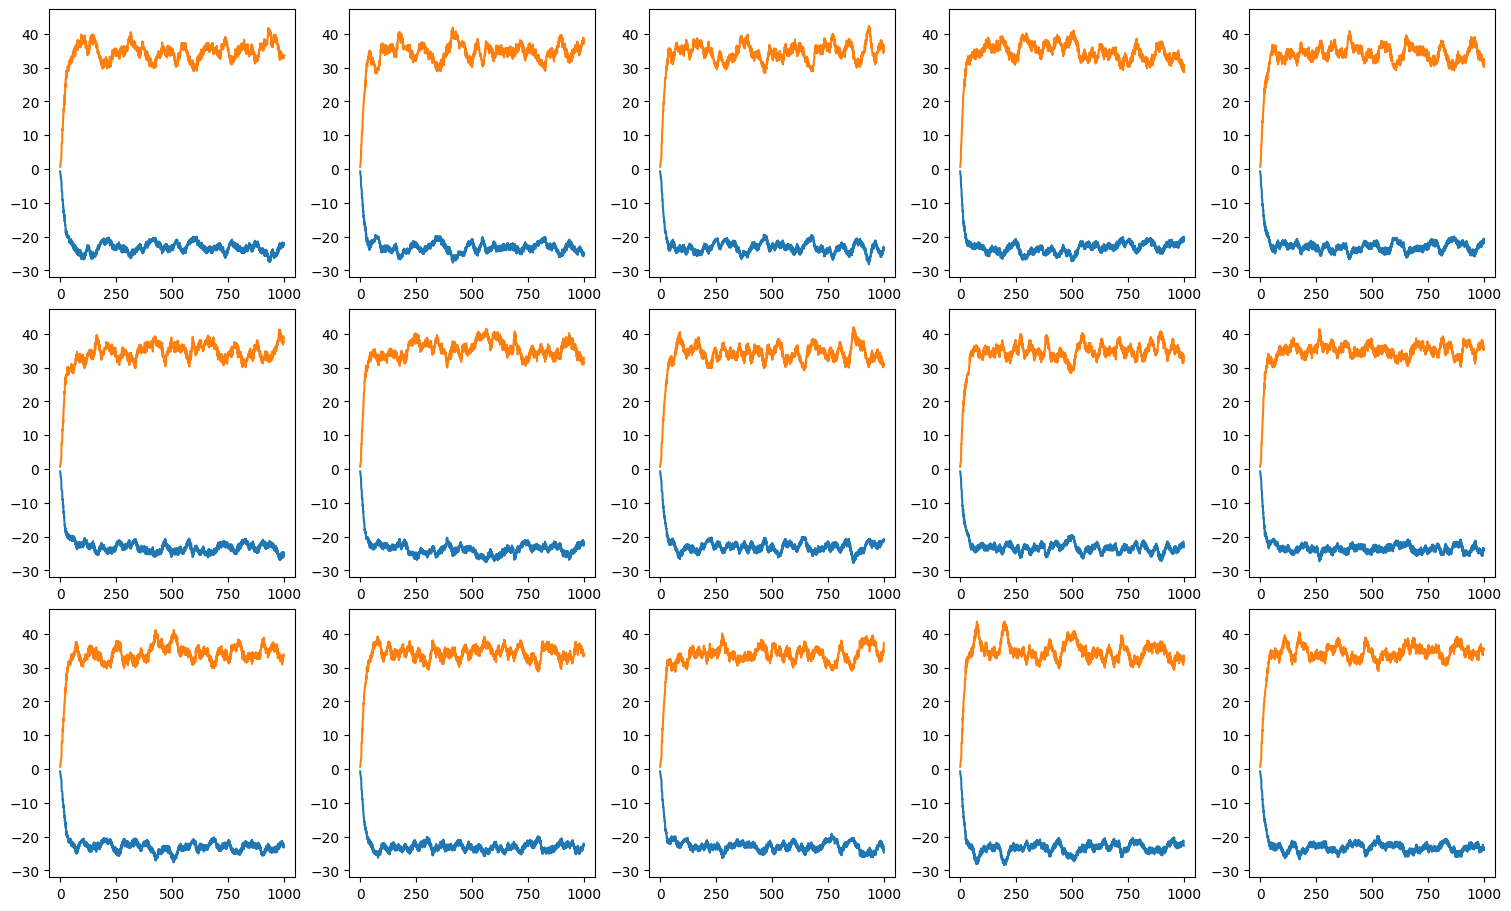

准确率 0.488


In [24]:
predict_and_visualize_net_activity(net)